In [1]:
!pip install xlrd
!pip install adversarial-robustness-toolbox
!pip install -U imbalanced-learn
!pip install shap
!pip install memory-profiler

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
from collections import Counter
import sys
import os
import pandas as pd
import numpy as np
import requests, io
import matplotlib.pyplot as plt
from numpy import mean
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE,SVMSMOTE, KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import NearestNeighbors
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.layers import Input
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.constraints import MaxNorm

from art.attacks.inference.membership_inference import MembershipInferenceBlackBox
from art.estimators.classification import KerasClassifier

tf.compat.v1.disable_v2_behavior()
tf.compat.v1.enable_eager_execution()


2024-09-18 01:07:33.905589: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-18 01:07:34.773865: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
class PPSMOTE:

    def __init__(self, k_neighbors=2, random_state=None):
        if isinstance(k_neighbors, int):
            if k_neighbors > 0:
                self.k_neighbors = k_neighbors
            else:
                raise ValueError('k_neighbors should be integer greater than 0')
        else:
            raise TypeError('Expect integer for k_neighbors')

        if isinstance(random_state, int):
            np.random.seed(random_state)

    def _laplaceNoise(self, mu, b, size):
        return np.random.laplace(mu, b, size)

    def _randomize(self, samples, target_size):
        length = samples.shape[0]
        idx = np.random.randint(length, size=target_size)
        return samples[idx, :]

    def _populate(self, idx, nnarray, minority_samples, noise):
        noise = self._laplaceNoise(0, noise, self.numattrs)

        for attr in range(self.numattrs):
            nn = np.random.randint(low=0, high=self.k_neighbors)
            dif = (minority_samples[nnarray[nn]][attr] - minority_samples[idx][attr])
            self.synthetic[self.newidx][attr] = (minority_samples[idx][attr] + noise[attr] * dif)
        self.newidx += 1

    def oversample(self, samples, labels, noise, merge=False):
      # Convert to numpy array if list is passed
      if isinstance(samples, list):
          self.samples = np.array(samples)
      elif isinstance(samples, np.ndarray):
          self.samples = samples
      else:
          raise TypeError('Expect a built-in list or an ndarray for samples')

      if isinstance(labels, list):
          labels = np.array(labels)

      # Find class counts for all classes
      class_counts = Counter(labels)
      majority_class = max(class_counts, key=class_counts.get)
      majority_size = class_counts[majority_class]

      # Initialize lists to store synthetic samples and labels
      synthetic_samples_list = []
      synthetic_labels_list = []

      # Loop through each class, oversampling minority classes
      for class_label, class_size in class_counts.items():
          if class_size < majority_size:
              # This is a minority class, oversample it
              minority_samples = self.samples[labels == class_label]
              self.numattrs = minority_samples.shape[1]

              # Calculate how many synthetic samples are needed to balance the class
              synthetic_needed = majority_size - class_size
              self.synthetic = np.empty(shape=(synthetic_needed, self.numattrs))
              self.newidx = 0

              # Nearest neighbor calculation on the minority samples
              self.nbrs = NearestNeighbors(n_neighbors=self.k_neighbors)
              self.nbrs.fit(minority_samples)
              self.knn = self.nbrs.kneighbors()[1]

              # Populate synthetic samples for the minority class
              for _ in range(synthetic_needed):
                  idx = np.random.randint(low=0, high=minority_samples.shape[0])
                  nnarray = self.knn[idx]
                  self._populate(idx, nnarray, minority_samples, noise)

              # Store the synthetic samples and their labels
              synthetic_samples_list.append(self.synthetic)
              synthetic_labels_list.append([class_label] * self.synthetic.shape[0])

      # Combine synthetic samples for all minority classes
      if synthetic_samples_list:
          synthetic_samples = np.vstack(synthetic_samples_list)
          synthetic_labels = np.concatenate(synthetic_labels_list)

      # Return the oversampled data
      if merge and synthetic_samples_list:
          # Merge the synthetic samples with the original dataset (both minority and majority)
          return np.concatenate((self.samples, synthetic_samples)), np.concatenate((labels, synthetic_labels))
      elif merge and not synthetic_samples_list:
          return self.samples, labels  # No oversampling was needed
      else:
          # Only return synthetic minority samples if there are any
          if synthetic_samples_list:
              return synthetic_samples, synthetic_labels
          else:
              return np.array([]), np.array([])  # No synthetic samples generated



In [5]:
dataset = pd.read_csv(r"PUDF_base1q2009_tab.csv")
dataset = dataset.dropna()
dataset = dataset.drop(['RECORD_ID','PAT_AGE','PAT_STATUS'],axis=1)
dataset['SEX_CODE'] = pd.Categorical(dataset['SEX_CODE']).codes
dataset['ADMITTING_DIAGNOSIS'] = pd.Categorical(dataset['ADMITTING_DIAGNOSIS']).codes
dataset['PRINC_DIAG_CODE'] = pd.Categorical(dataset['PRINC_DIAG_CODE']).codes
dataset['OTH_DIAG_CODE_1'] = pd.Categorical(dataset['OTH_DIAG_CODE_1']).codes
dataset['OCCUR_DAY_1'] = pd.Categorical(dataset['OCCUR_DAY_1']).codes
dataset['OCCUR_CODE_1'] = pd.Categorical(dataset['OCCUR_CODE_1']).codes
dataset['HCFA_MDC'] = pd.Categorical(dataset['HCFA_MDC']).codes
dataset['ETHNICITY'] = pd.Categorical(dataset['ETHNICITY']).codes
dataset['SOURCE_OF_ADMISSION'] = pd.Categorical(dataset['SOURCE_OF_ADMISSION']).codes
dataset['RACE'] = pd.Categorical(dataset['RACE']).codes
dataset['LENGTH_OF_STAY'] = pd.Categorical(dataset['LENGTH_OF_STAY']).codes
dataset['TYPE_OF_ADMISSION'] = pd.Categorical(dataset['TYPE_OF_ADMISSION']).codes
dataset['APR_MDC'] = pd.Categorical(dataset['APR_MDC']).codes
dataset['HCFA_DRG'] = pd.Categorical(dataset['HCFA_DRG']).codes
dataset['APR_DRG'] = pd.Categorical(dataset['APR_DRG']).codes
dataset['ILLNESS_SEVERITY'] = pd.Categorical(dataset['ILLNESS_SEVERITY']).codes
dataset['RISK_MORTALITY'] = pd.Categorical(dataset['RISK_MORTALITY']).codes
RISK_MORTALITY_MAP = {1:0,2:1,3:2,4:3}
dataset['RISK_MORTALITY'] = dataset['RISK_MORTALITY'].replace(RISK_MORTALITY_MAP)

#dataset = dataset.iloc[:380000]
print(dataset.size)
dataset.head()

/tmp/ipykernel_89191/2505708233.py:1: DtypeWarning: Columns (1,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  dataset = pd.read_csv(r"PUDF_base1q2009_tab.csv")


8091609


,SEX_CODE,TYPE_OF_ADMISSION,SOURCE_OF_ADMISSION,LENGTH_OF_STAY,RACE,ETHNICITY,ADMITTING_DIAGNOSIS,PRINC_DIAG_CODE,OTH_DIAG_CODE_1,OCCUR_CODE_1,OCCUR_DAY_1,HCFA_MDC,APR_MDC,HCFA_DRG,APR_DRG,ILLNESS_SEVERITY,RISK_MORTALITY
0,1,1,9,2,3,1,847,984,971,2,1610,19,19,673,277,1,0
1,0,1,9,2,2,1,892,1043,5862,2,1610,19,19,674,275,1,0
2,0,1,9,53,2,1,892,1043,5862,2,1610,19,19,674,275,2,0
3,0,1,9,8,2,1,892,1043,1047,2,1610,19,19,674,275,2,0
4,0,1,9,17,3,1,892,1043,4413,2,1610,19,19,674,275,1,0


In [6]:
X = dataset.to_numpy()[:,:16]
y = dataset.to_numpy()[:,-1]
unique_values = np.unique(y)
print("Unique values:", unique_values)

Unique values: [0 1 2 3]


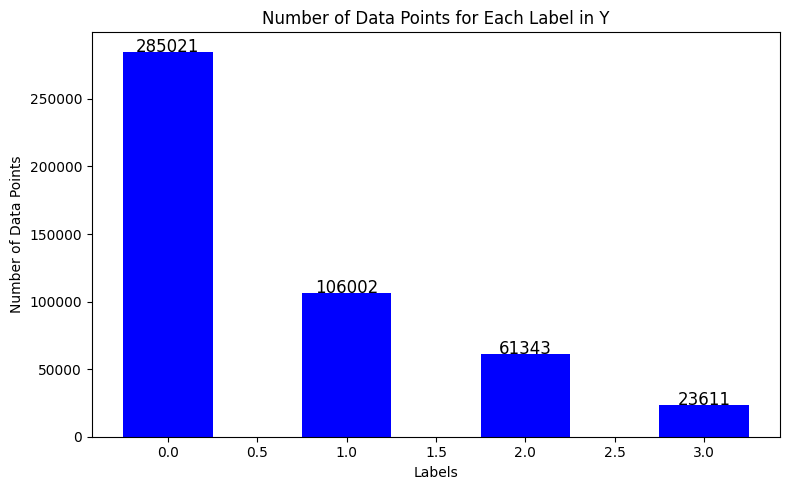

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
# Get unique labels in y
# Get unique labels and their counts
unique_labels, label_counts = np.unique(y, return_counts=True)

# Plotting the bar chart
plt.figure(figsize=(8, 5))
plt.bar(unique_labels, label_counts, color='blue', width=0.5)

# Labels and title
plt.xlabel('Labels')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points for Each Label in Y')

# Adding label values on top of the bars
for i, count in enumerate(label_counts):
    plt.text(unique_labels[i], count + 0.1, str(count), ha='center', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


In [8]:
smote = PPSMOTE(k_neighbors=5, random_state=42)
start_time = time.time()
X_train_3, y_train_3 = smote.oversample(X, y, 0.4, merge=True)
end_time = time.time()

# Calculate runtime
runtime_in_seconds = end_time - start_time
print(f"PP-SMOTE resampling runtime: {runtime_in_seconds:.4f} seconds")

X_train_3.shape

PP-SMOTE resampling runtime: 351.5505 seconds


(1140084, 16)

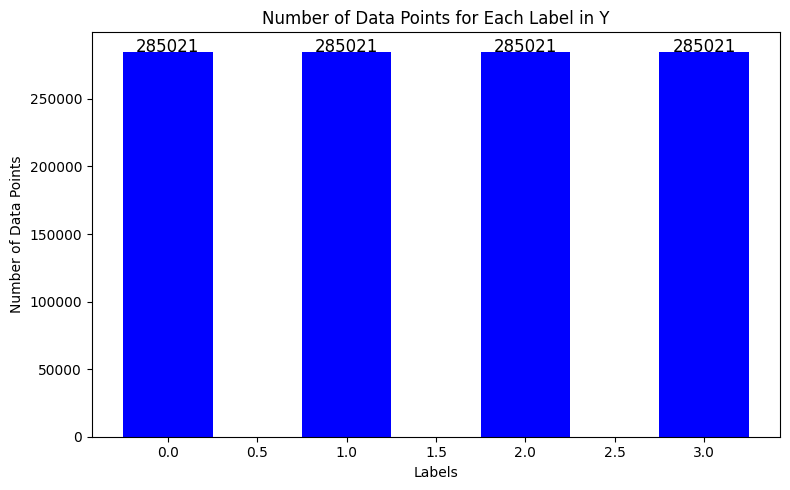

In [9]:
# Get unique labels in y
# Get unique labels and their counts
unique_labels, label_counts = np.unique(y_train_3, return_counts=True)

# Plotting the bar chart
plt.figure(figsize=(8, 5))
plt.bar(unique_labels, label_counts, color='blue', width=0.5)

# Labels and title
plt.xlabel('Labels')
plt.ylabel('Number of Data Points')
plt.title('Number of Data Points for Each Label in Y')

# Adding label values on top of the bars
for i, count in enumerate(label_counts):
    plt.text(unique_labels[i], count + 0.1, str(count), ha='center', fontsize=12)

# Display the plot
plt.tight_layout()
plt.show()


In [10]:


# Initialize the resamplers
smote = SMOTE()
adasyn = ADASYN()
svm_smote = SVMSMOTE()
borderline_smote = BorderlineSMOTE()

# Function to measure the runtime of a resampler
def measure_runtime(resampler, X, y):
    start_time = time.time()
    x_resampled, y_resampled = resampler.fit_resample(X, y)
    end_time = time.time()
    return end_time - start_time

# Measure runtime for each method
runtime_smote = measure_runtime(smote, X, y)
print(f"SMOTE runtime: {runtime_smote:.4f} seconds")
runtime_adasyn = measure_runtime(adasyn, X, y)
print(f"ADASYN runtime: {runtime_adasyn:.4f} seconds")
#runtime_svm_smote = measure_runtime(svm_smote, X, y)
#print(f"SVM SMOTE runtime: {runtime_svm_smote:.4f} seconds")
runtime_borderline_smote = measure_runtime(borderline_smote, X, y)
print(f"Borderline SMOTE runtime: {runtime_borderline_smote:.4f} seconds")


SMOTE runtime: 312.0955 seconds
ADASYN runtime: 1932.0580 seconds
Borderline SMOTE runtime: 1783.6382 seconds


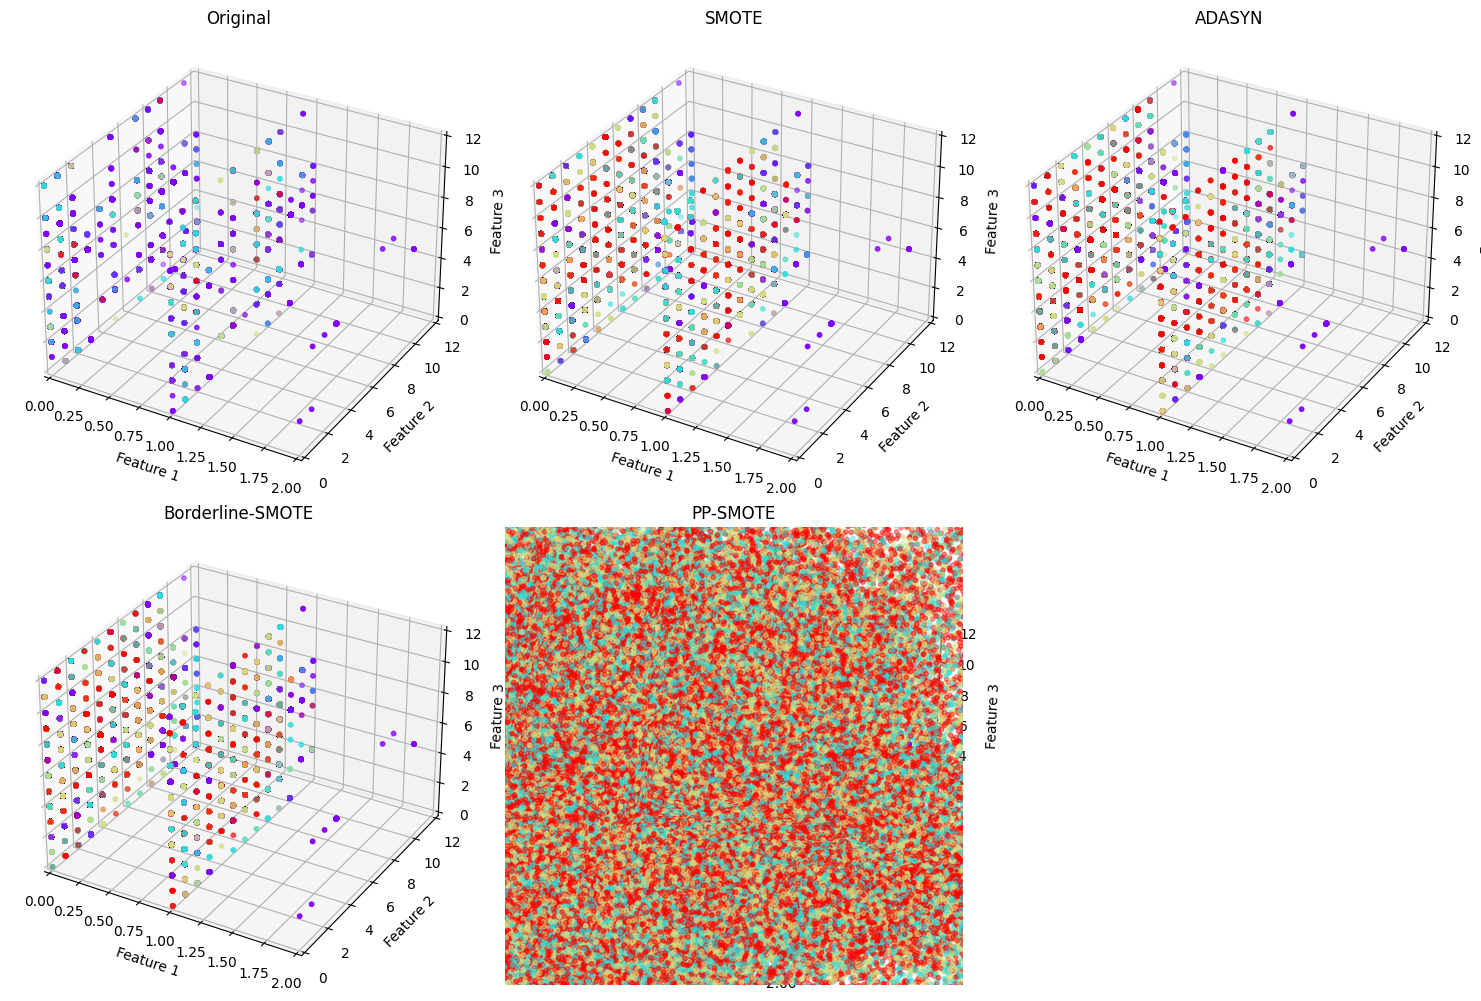

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, RandomOverSampler
from sklearn.datasets import make_classification
import numpy as np

# Define different resampling methods
resampling_methods = {
    'Original': (X, y),  # No resampling
    'SMOTE': SMOTE(),
    'ADASYN': ADASYN(),
    'Borderline-SMOTE': BorderlineSMOTE(),
    'PP-SMOTE': PPSMOTE(k_neighbors=5, random_state=42),
}

# Plotting in a 3x3 grid (change depending on the number of methods)
fig = plt.figure(figsize=(15, 15))

for i, (method_name, resampler) in enumerate(resampling_methods.items()):
    ax = fig.add_subplot(3, 3, i+1, projection='3d')
    
    if method_name == 'Original':
        # No resampling, use original dataset
        x_res, y_res = X, y
    elif method_name == 'PP-SMOTE':
        x_res, y_res = resampler.oversample(X, y, 1.0, merge=True)
    else:
        # Apply the resampling technique
        x_res, y_res = resampler.fit_resample(X, y)

    # Create 3D scatter plot
    ax.scatter(x_res[:, 0], x_res[:, 1], x_res[:, 2], c=y_res, cmap='rainbow', s=10)
    ax.set_title(method_name)

    # Optional: axis limits and labels
    ax.set_xlim([X[:, 0].min(), X[:, 0].max()])
    ax.set_ylim([X[:, 1].min(), X[:, 1].max()])
    ax.set_zlim([X[:, 2].min(), X[:, 2].max()])
    ax.set_xlabel('Feature 1')
    ax.set_ylabel('Feature 2')
    ax.set_zlabel('Feature 3')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()
